In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from RadarCameraYOLO import RadarCameraYoloDataset, RadarCameraYOLO

# ✅ 학습된 모델 불러오기
model = RadarCameraYOLO(num_classes=7)
model.load_state_dict(torch.load("./trained_model.pth"))
model.eval()

⚠️ Running on CPU mode only
🚀 Training started!


/opt/conda/envs/rcfd/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch [1/1], Step [0/18], Class Loss: 2.0395, BBox Loss: 0.0563, Total Loss: 2.0958
Epoch [1/1], Step [5/18], Class Loss: 1.7542, BBox Loss: 0.0373, Total Loss: 1.7915
Epoch [1/1], Step [10/18], Class Loss: 1.2960, BBox Loss: 0.0165, Total Loss: 1.3125
Epoch [1/1], Step [15/18], Class Loss: 0.9494, BBox Loss: 0.0052, Total Loss: 0.9546
✅ Epoch 1 completed.
✅ Training Completed!
✅ Model saved as trained_model.pth


RadarCameraYOLO(
  (camera_stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): CSPBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bottlenecks): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stri

In [3]:
from WaterScenes.radar_map_generate import RESOLUTION

# ✅ 데이터셋 불러오기
data_root = "/workspaces/Radar-Camera-Fusion-Detection/WaterScenes/sample_dataset"  # 데이터 경로
input_shape = (RESOLUTION, RESOLUTION)

dataset = RadarCameraYoloDataset(data_root=data_root, input_shape=input_shape)

In [4]:
from torchvision import transforms, ops
import pdb

def visualize_predictions(model, dataset, num_samples=5, confidence_threshold=0.5, iou_threshold=0.4):
    """
    모델이 예측한 bbox와 정답 bbox를 시각화하는 함수 (NMS 적용)

    :param model: 학습된 RadarCameraYOLO 모델
    :param dataset: RadarCameraYoloDataset 데이터셋 객체
    :param num_samples: 시각화할 샘플 개수
    :param confidence_threshold: bbox 표시를 위한 신뢰도 임계값
    :param iou_threshold: NMS에서 사용하는 IoU 임계값
    """
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        image, radar, labels = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()
        
        # 모델 예측
        with torch.no_grad():
            class_output, bbox_output = model(image.unsqueeze(0), radar.unsqueeze(0))
        
        # 클래스 및 confidence 계산
        class_prob = torch.softmax(class_output, dim=1)
        confidence, pred_classes = torch.max(class_prob, dim=1)
        
        # Bounding Box 정보 추출
        pred_boxes = bbox_output.squeeze(0).cpu().numpy().reshape(-1, 4)
        conf_scores = confidence.squeeze(0).cpu().numpy().flatten()
        pred_classes = pred_classes.squeeze(0).cpu().numpy().flatten()
        
        # NMS 적용
        if len(pred_boxes) > 0:
            pred_boxes_tensor = torch.tensor(pred_boxes, dtype=torch.float32)
            conf_scores_tensor = torch.tensor(conf_scores, dtype=torch.float32)
            nms_indices = ops.nms(pred_boxes_tensor, conf_scores_tensor, iou_threshold)
            
            pred_boxes = pred_boxes_tensor[nms_indices].numpy()
            conf_scores = conf_scores_tensor[nms_indices].numpy()
            pred_classes = pred_classes[nms_indices]

            print("Sample Predicted BBoxes:", pred_boxes[:5])
        
            
        print(f"Before NMS: {len(pred_boxes)} predictions")
        print(f"After NMS: {len(nms_indices)} predictions")
        
        # 정답 bbox 시각화
        ax1 = axes[i][0]
        ax1.imshow(image_np)
        ax1.set_title("Ground Truth")
        for obj in labels:
            class_id, x, y, w, h = obj.numpy()
            rect = patches.Rectangle(((x - w/2) * image_np.shape[1], (y - h/2) * image_np.shape[0]),
                                     w * image_np.shape[1], h * image_np.shape[0],
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax1.add_patch(rect)
            ax1.text((x - w/2) * image_np.shape[1], (y - h/2) * image_np.shape[0],
                     f"GT: {int(class_id)}", color='g', fontsize=12, weight='bold')
        
        # 예측 bbox 시각화
        ax2 = axes[i][1]
        ax2.imshow(image_np)
        ax2.set_title("Predictions")
        for j in range(pred_boxes.shape[0]):
            if conf_scores[j] > confidence_threshold:
                x, y, w, h = pred_boxes[j]
                rect = patches.Rectangle(((x - w/2) * image_np.shape[1], (y - h/2) * image_np.shape[0]),
                                         w * image_np.shape[1], h * image_np.shape[0],
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax2.add_patch(rect)
                ax2.text((x - w/2) * image_np.shape[1], (y - h/2) * image_np.shape[0],
                         f"Pred: {int(pred_classes[j])} ({conf_scores[j]:.2f})", 
                         color='r', fontsize=12, weight='bold')
        
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Predicted BBoxes: [[0.03226176 0.03228161 0.03226919 0.03220454]
 [0.03197789 0.03206277 0.03198858 0.03184645]
 [0.03169908 0.03171785 0.03182153 0.03210483]
 [0.03193182 0.03192797 0.03198366 0.03195499]
 [0.03211041 0.03209864 0.03213185 0.03209819]]
Before NMS: 349 predictions
After NMS: 349 predictions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Predicted BBoxes: [[0.03169927 0.03175585 0.03185005 0.0319313 ]
 [0.03194559 0.03193015 0.03192988 0.03196201]
 [0.03200528 0.03189355 0.03185534 0.03172059]
 [0.03176315 0.03177035 0.03180838 0.03179803]
 [0.03210862 0.03212368 0.03211793 0.03209174]]
Before NMS: 359 predictions
After NMS: 359 predictions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Predicted BBoxes: [[ 0.03207336  0.03209317  0.0321019   0.03210206]
 [ 0.03154576  0.03169055  0.03169498  0.0318391 ]
 [ 0.03196126  0.0321169   0.03218496  0.03208193]
 [ 0.03179045  0.03185874  0.03194135  0.03196788]
 [-0.1361304  -0.13609244 -0.13608211 -0.13605563]]
Before NMS: 349 predictions
After NMS: 349 predictions
Sample Predicted BBoxes: [[0.03219505 0.03232364 0.03237464 0.03234145]
 [0.03224643 0.03230736 0.03224391 0.03220552]
 [0.03227949 0.03218132 0.03215271 0.03210996]
 [0.03203255 0.03197303 0.03192157 0.03190202]
 [0.01558366 0.02786145 0.03107391 0.03179482]]
Before NMS: 352 predictions
After NMS: 352 predictions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Predicted BBoxes: [[0.03231683 0.03234653 0.03218606 0.03219438]
 [0.0314485  0.03147703 0.03147872 0.03157161]
 [0.03150147 0.03169185 0.03196941 0.03221472]
 [0.03185698 0.03188039 0.03193648 0.03195858]
 [0.03152071 0.03135504 0.03126769 0.0313856 ]]
Before NMS: 355 predictions
After NMS: 355 predictions


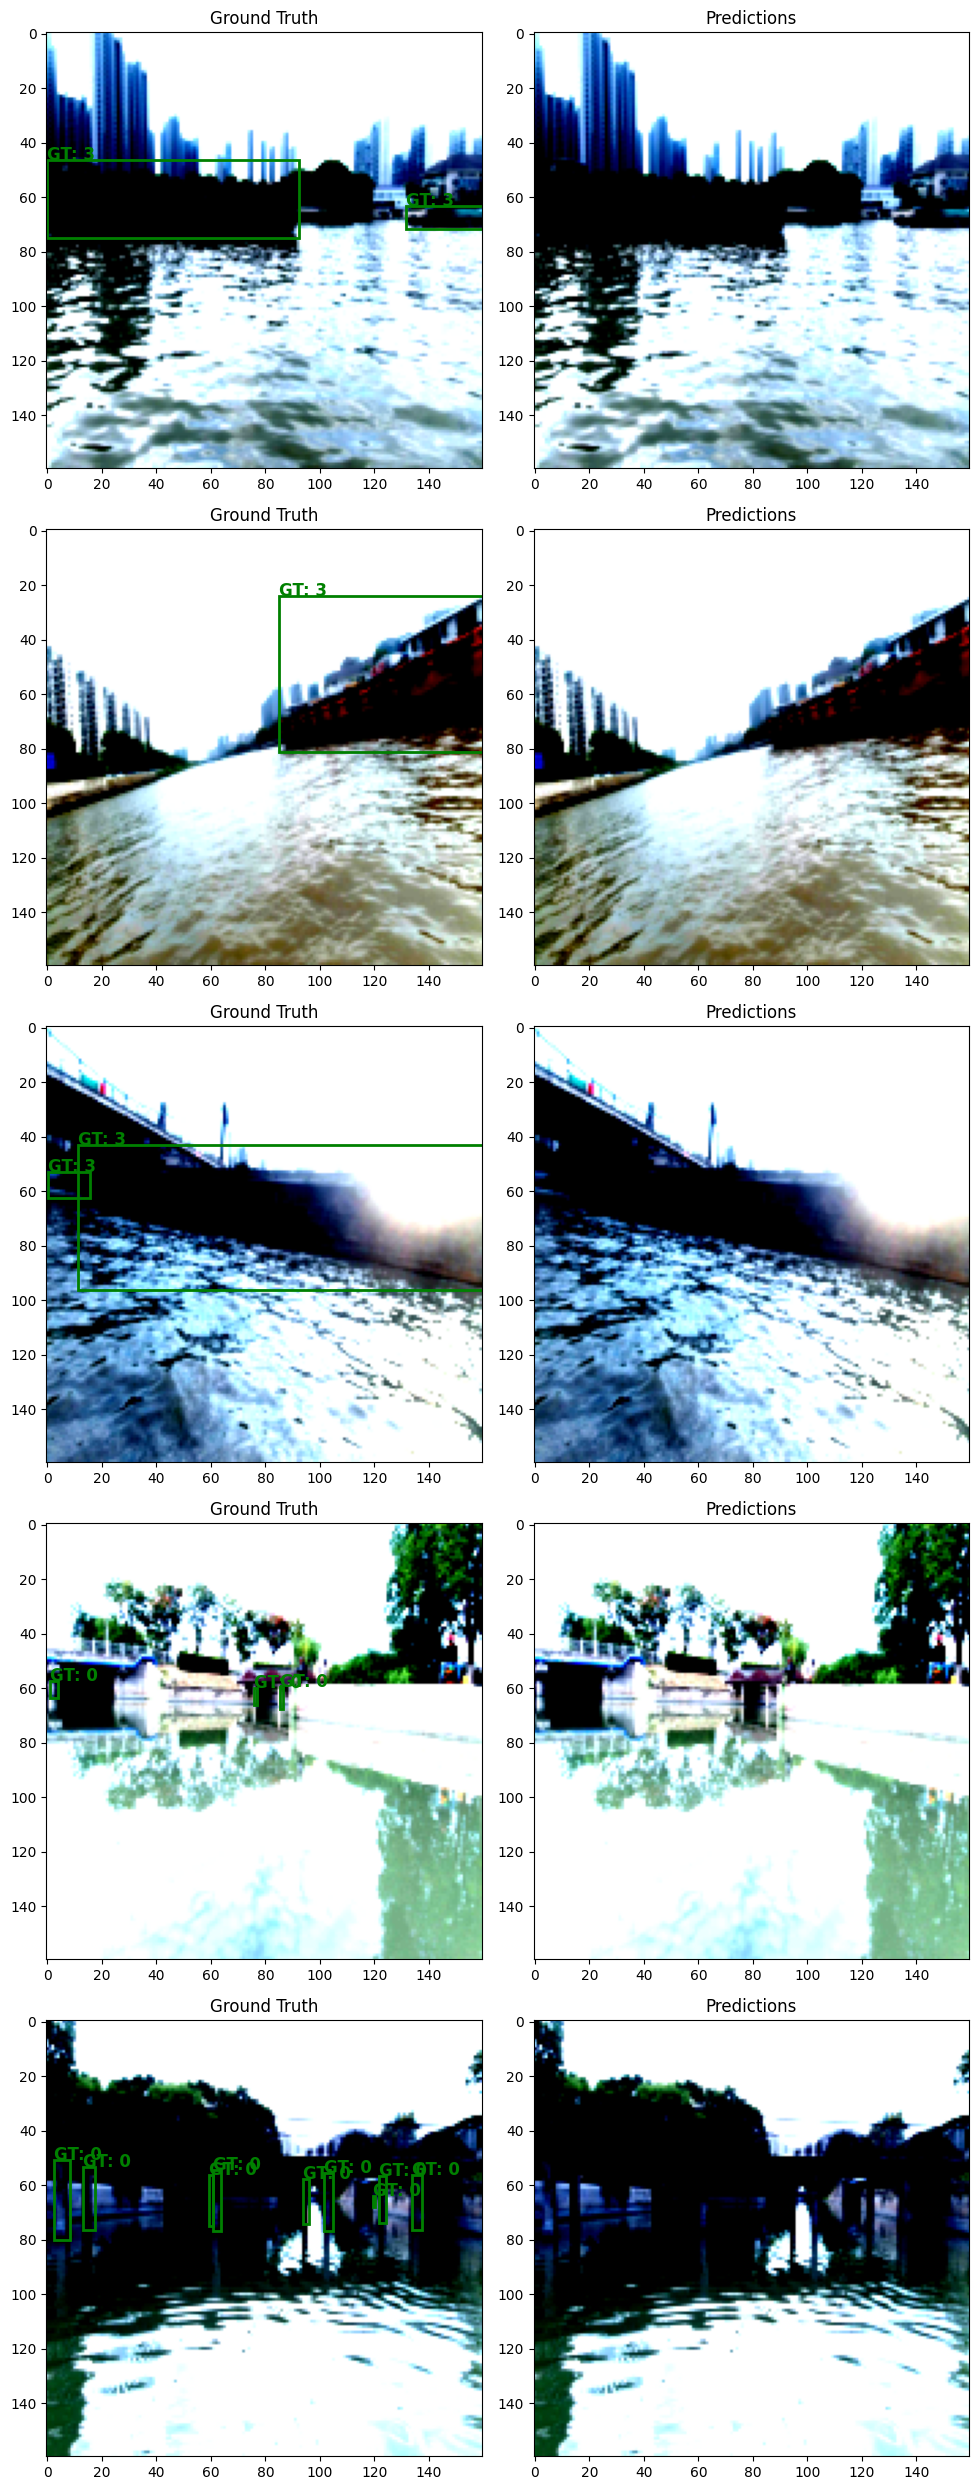

In [5]:
# ✅ 실행 예시
visualize_predictions(model, dataset, num_samples=5, confidence_threshold=0.8, iou_threshold=0.4)